# Build a linear model with Estimators
This tutorial uses the [tf.estimator](https://www.tensorflow.org/api_docs/python/tf/estimator) API in TensorFlow to solve a benchmark binary classification problem. Estimators are TensorFlow's most scalable and production-oriented model type. For more information see the [Estimator guide](https://www.tensorflow.org/guide/estimators).



# Overview
Using census data which contains data a person's age, education, marital status, and occupation (the features), we will try to predict whether or not the person earns more than 50,000 dollars a year (the target label). We will train a logistic regression model that, given an individual's information, outputs a number between 0 and 1—this can be interpreted as the probability that the individual has an annual income of over 50,000 dollars.



---

**Key Point**: As a modeler and developer, think about how this data is used and the potential benefits and harm a model's predictions can cause. A model like this could reinforce societal biases and disparities. Is each feature relevant to the problem you want to solve or will it introduce bias? For more information, read about [ML fairness](https://developers.google.com/machine-learning/fairness-overview/).

# Setup
Import TensorFlow, feature column support, and supporting modules:

In [0]:
import tensorflow as tf
import tensorflow.feature_column as fc 

import os
import sys

import matplotlib.pyplot as plt
from IPython.display import clear_output

And let's enable [eager execution](https://www.tensorflow.org/guide/eager) to inspect this program as we run it:



In [0]:
tf.enable_eager_execution()

# Download the official implementation
We'll use the [wide and deep model](https://github.com/tensorflow/models/tree/master/official/wide_deep/) available in TensorFlow's [model repository](https://github.com/tensorflow/models/). Download the code, add the root directory to your Python path, and jump to the `wide_deep` directory:

In [3]:
! pip install -q requests
! git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2973, done.
remote: Counting objects: 100% (2973/2973), done.
remote: Compressing objects: 100% (2574/2574), done.
remote: Total 2973 (delta 507), reused 1775 (delta 323), pack-reused 0
Receiving objects: 100% (2973/2973), 376.91 MiB | 41.52 MiB/s, done.
Resolving deltas: 100% (507/507), done.
Checking out files: 100% (2804/2804), done.


Add the root directory of the repository to your Python path:



In [0]:
models_path = os.path.join(os.getcwd(), 'models')

sys.path.append(models_path)

Download the dataset:



In [0]:
from official.wide_deep import census_dataset
from official.wide_deep import census_main

census_dataset.download("/tmp/census_data/")

**Command line usage**

The repo includes a complete program for experimenting with this type of model.

To execute the tutorial code from the command line first add the path to tensorflow/models to your `PYTHONPATH`.

In [0]:
#export PYTHONPATH=${PYTHONPATH}:"$(pwd)/models"
#running from python you need to set the `os.environ` or the subprocess will not see the directory.

if "PYTHONPATH" in os.environ:
  os.environ['PYTHONPATH'] += os.pathsep +  models_path
else:
  os.environ['PYTHONPATH'] = models_path

Use `--help` to see what command line options are available:



In [7]:
!python -m official.wide_deep.census_main --help

2018-10-02 18:21:16.713016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:964] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-10-02 18:21:16.713474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1411] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
totalMemory: 11.17GiB freeMemory: 11.10GiB
2018-10-02 18:21:16.713543: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1490] Adding visible gpu devices: 0
2018-10-02 18:21:17.080240: I tensorflow/core/common_runtime/gpu/gpu_device.cc:971] Device interconnect StreamExecutor with strength 1 edge matrix:
2018-10-02 18:21:17.080306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977]      0 
2018-10-02 18:21:17.080334: I tensorflow/core/common_runtime/gpu/gpu_device.cc:990] 0:   N 
2018-10-02 18:21:17.080621: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:

Now run the model:



In [8]:
!python -m official.wide_deep.census_main --model_type=wide --train_epochs=2

2018-10-02 18:21:23.219222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:964] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-10-02 18:21:23.219701: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1411] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
totalMemory: 11.17GiB freeMemory: 11.10GiB
2018-10-02 18:21:23.219743: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1490] Adding visible gpu devices: 0
2018-10-02 18:21:23.602915: I tensorflow/core/common_runtime/gpu/gpu_device.cc:971] Device interconnect StreamExecutor with strength 1 edge matrix:
2018-10-02 18:21:23.602984: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977]      0 
2018-10-02 18:21:23.603011: I tensorflow/core/common_runtime/gpu/gpu_device.cc:990] 0:   N 
2018-10-02 18:21:23.603291: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:

# Read the U.S. Census data
This example uses the [U.S Census Income Dataset](https://archive.ics.uci.edu/ml/datasets/Census+Income) from 1994 and 1995. We have provided the [census_dataset.py](https://github.com/tensorflow/models/tree/master/official/wide_deep/census_dataset.py) script to download the data and perform a little cleanup.

Since the task is a binary classification problem, we'll construct a label column named "label" whose value is 1 if the income is over 50K, and 0 otherwise. For reference, see the `input_fn` in [census_main.py](https://github.com/tensorflow/models/tree/master/official/wide_deep/census_main.py).

Let's look at the data to see which columns we can use to predict the target label:



In [9]:
!ls  /tmp/census_data/

adult.data  adult.test


In [0]:
train_file = "/tmp/census_data/adult.data"
test_file = "/tmp/census_data/adult.test"

[pandas](https://pandas.pydata.org/) provides some convenient utilities for data analysis. Here's a list of columns available in the Census Income dataset:



In [11]:
import pandas

train_df = pandas.read_csv(train_file, header = None, names = census_dataset._CSV_COLUMNS)
test_df = pandas.read_csv(test_file, header = None, names = census_dataset._CSV_COLUMNS)

train_df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


The columns are grouped into two types: categorical and continuous columns:

* A column is called categorical if its value can only be one of the categories in a finite set. For example, the relationship status of a person (wife, husband, unmarried, etc.) or the education level (high school, college, etc.) are categorical columns.
* A column is called continuous if its value can be any numerical value in a continuous range. For example, the capital gain of a person (e.g. $14,084) is a continuous column.


# Converting Data into Tensors
When building a [tf.estimator](https://www.tensorflow.org/api_docs/python/tf/estimator) model, the input data is specified by using an input function (or `input_fn`). This builder function returns a tf[.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) of batches of (`features-dict, label`) pairs. It is not called until it is passed to [tf.estimator.Estimator](https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator) methods such as `train` and `evaluate`.

The input builder function returns the following pair:

1. `features`: A dict from feature names to `Tensors` or `SparseTensors` containing batches of features.
2. `labels`: A `Tensor` containing batches of labels.

The keys of the `features` are used to configure the model's input layer.


---

**Note:** The input function is called while constructing the TensorFlow graph, not while running the graph. It is returning a representation of the input data as a sequence of TensorFlow graph operations.


---


For small problems like this, it's easy to make a [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) by slicing the `pandas.DataFrame`:



In [0]:
def easy_input_function(df, label_key, num_epochs, shuffle, batch_size):
  label = df[label_key]
  ds = tf.data.Dataset.from_tensor_slices((dict(df),label))

  if shuffle:
    ds = ds.shuffle(10000)

  ds = ds.batch(batch_size).repeat(num_epochs)

  return ds

Since we have eager execution enabled, it's easy to inspect the resulting dataset:



In [13]:
ds = easy_input_function(train_df, label_key='income_bracket', num_epochs=5, shuffle=True, batch_size=10)

for feature_batch, label_batch in ds.take(1):
  print('Some feature keys:', list(feature_batch.keys())[:5])
  print()
  print('A batch of Ages  :', feature_batch['age'])
  print()
  print('A batch of Labels:', label_batch )

Some feature keys: ['age', 'workclass', 'fnlwgt', 'education', 'education_num']

A batch of Ages  : tf.Tensor([49 58 53 28 26 35 48 36 63 39], shape=(10,), dtype=int32)

A batch of Labels: tf.Tensor(
[b'<=50K' b'>50K' b'<=50K' b'<=50K' b'<=50K' b'<=50K' b'<=50K' b'<=50K'
 b'<=50K' b'>50K'], shape=(10,), dtype=string)


But this approach has severly-limited scalability. Larger datasets should be streamed from disk. The `census_dataset.input_fn` provides an example of how to do this using [tf.decode_csv](https://www.tensorflow.org/api_docs/python/tf/decode_csv) and [tf.data.TextLineDataset](https://www.tensorflow.org/api_docs/python/tf/data/TextLineDataset):

In [14]:
import inspect
print(inspect.getsource(census_dataset.input_fn))

def input_fn(data_file, num_epochs, shuffle, batch_size):
  """Generate an input function for the Estimator."""
  assert tf.gfile.Exists(data_file), (
      '%s not found. Please make sure you have run census_dataset.py and '
      'set the --data_dir argument to the correct path.' % data_file)

  def parse_csv(value):
    tf.logging.info('Parsing {}'.format(data_file))
    columns = tf.decode_csv(value, record_defaults=_CSV_COLUMN_DEFAULTS)
    features = dict(zip(_CSV_COLUMNS, columns))
    labels = features.pop('income_bracket')
    classes = tf.equal(labels, '>50K')  # binary classification
    return features, classes

  # Extract lines from input files using the Dataset API.
  dataset = tf.data.TextLineDataset(data_file)

  if shuffle:
    dataset = dataset.shuffle(buffer_size=_NUM_EXAMPLES['train'])

  dataset = dataset.map(parse_csv, num_parallel_calls=5)

  # We call repeat after shuffling, rather than before, to prevent separate
  # epochs from blending together.
  dataset = 

This `input_fn` returns equivalent output:



In [15]:
ds = census_dataset.input_fn(train_file, num_epochs=5, shuffle=True, batch_size=10)

for feature_batch, label_batch in ds.take(1):
  print('Feature keys:', list(feature_batch.keys())[:5])
  print()
  print('Age batch   :', feature_batch['age'])
  print()
  print('Label batch :', label_batch )

INFO:tensorflow:Parsing /tmp/census_data/adult.data


I1002 18:22:00.266650 140052242024320 tf_logging.py:115] Parsing /tmp/census_data/adult.data


Feature keys: ['age', 'workclass', 'fnlwgt', 'education', 'education_num']

Age batch   : tf.Tensor([27 44 53 25 50 42 47 17 47 54], shape=(10,), dtype=int32)

Label batch : tf.Tensor([False False  True  True False  True  True False  True False], shape=(10,), dtype=bool)


Because `Estimators` expect an `input_fn` that takes no arguments, we typically wrap configurable input function into an obejct with the expected signature. For this notebook configure the `train_inpf` to iterate over the data twice:



In [0]:
import functools

train_inpf = functools.partial(census_dataset.input_fn, train_file, num_epochs=2, shuffle=True, batch_size=64)
test_inpf = functools.partial(census_dataset.input_fn, test_file, num_epochs=1, shuffle=False, batch_size=64)

# Selecting and Engineering Features for the Model
Estimators use a system called [feature columns](https://www.tensorflow.org/guide/feature_columns) to describe how the model should interpret each of the raw input features. An Estimator expects a vector of numeric inputs, and feature columns describe how the model should convert each feature.

Selecting and crafting the right set of feature columns is key to learning an effective model. A feature column can be either one of the raw inputs in the original features `dict` (a base feature column), or any new columns created using transformations defined over one or multiple base columns (a derived feature columns).

A feature column is an abstract concept of any raw or derived variable that can be used to predict the target label.

## Base Feature Columns
### Numeric columns
The simplest `feature_column` is `numeric_column`. This indicates that a feature is a numeric value that should be input to the model directly. For example:



In [0]:
age = fc.numeric_column('age')

The model will use the `feature_column` definitions to build the model input. You can inspect the resulting output using the `input_layer` function:



In [18]:
fc.input_layer(feature_batch, [age]).numpy()

array([[27.],
       [44.],
       [53.],
       [25.],
       [50.],
       [42.],
       [47.],
       [17.],
       [47.],
       [54.]], dtype=float32)

The following will train and evaluate a model using only the `age` feature:



In [19]:
classifier = tf.estimator.LinearClassifier(feature_columns=[age])
classifier.train(train_inpf)
result = classifier.evaluate(test_inpf)

clear_output()  # used for display in notebook
print(result)

{'accuracy': 0.76352805, 'accuracy_baseline': 0.76377374, 'auc': 0.6781596, 'auc_precision_recall': 0.311341, 'average_loss': 0.5254081, 'label/mean': 0.23622628, 'loss': 33.54576, 'precision': 0.35714287, 'prediction/mean': 0.21536572, 'recall': 0.001300052, 'global_step': 1018}


Similarly, we can define a `NumericColumn` for each continuous feature column that we want to use in the model:



In [20]:
education_num = tf.feature_column.numeric_column('education_num')
capital_gain = tf.feature_column.numeric_column('capital_gain')
capital_loss = tf.feature_column.numeric_column('capital_loss')
hours_per_week = tf.feature_column.numeric_column('hours_per_week')

my_numeric_columns = [age,education_num, capital_gain, capital_loss, hours_per_week]

fc.input_layer(feature_batch, my_numeric_columns).numpy()

array([[2.700e+01, 0.000e+00, 0.000e+00, 1.300e+01, 4.000e+01],
       [4.400e+01, 0.000e+00, 0.000e+00, 1.000e+01, 6.000e+01],
       [5.300e+01, 0.000e+00, 0.000e+00, 1.100e+01, 4.000e+01],
       [2.500e+01, 5.178e+03, 0.000e+00, 7.000e+00, 4.000e+01],
       [5.000e+01, 0.000e+00, 0.000e+00, 1.000e+01, 4.000e+01],
       [4.200e+01, 9.562e+03, 0.000e+00, 1.300e+01, 4.500e+01],
       [4.700e+01, 0.000e+00, 0.000e+00, 1.000e+01, 5.000e+01],
       [1.700e+01, 0.000e+00, 0.000e+00, 7.000e+00, 5.000e+00],
       [4.700e+01, 7.688e+03, 0.000e+00, 1.400e+01, 4.500e+01],
       [5.400e+01, 0.000e+00, 0.000e+00, 9.000e+00, 4.000e+01]],
      dtype=float32)

You could retrain a model on these features by changing the `feature_columns` argument to the constructor:



In [21]:
classifier = tf.estimator.LinearClassifier(feature_columns=my_numeric_columns)
classifier.train(train_inpf)

result = classifier.evaluate(test_inpf)

clear_output()

for key,value in sorted(result.items()):
  print('%s: %s' % (key, value))

accuracy: 0.787728
accuracy_baseline: 0.76377374
auc: 0.70704854
auc_precision_recall: 0.5409346
average_loss: 0.5204191
global_step: 1018
label/mean: 0.23622628
loss: 33.22723
precision: 0.6575121
prediction/mean: 0.23421305
recall: 0.21164846


### Categorical columns
To define a feature column for a categorical feature, create a `CategoricalColumn` using one of the `tf.feature_column.categorical_column*` functions.

If you know the set of all possible feature values of a column—and there are only a few of them—use `categorical_column_with_vocabulary_list`. Each key in the list is assigned an auto-incremented ID starting from 0. For example, for the `relationship` column we can assign the feature string `Husband` to an integer ID of 0 and "Not-in-family" to 1, etc.

In [0]:
relationship = fc.categorical_column_with_vocabulary_list(
    'relationship',
    ['Husband', 'Not-in-family', 'Wife', 'Own-child', 'Unmarried', 'Other-relative'])

This creates a sparse one-hot vector from the raw input feature.

The `input_layer` function we're using is designed for DNN models and expects dense inputs. To demonstrate the categorical column we must wrap it in a [tf.feature_column.indicator_column](https://www.tensorflow.org/api_docs/python/tf/feature_column/indicator_column) to create the dense one-hot output (Linear `Estimators` can often skip this dense-step).



---


Note: the other sparse-to-dense option is [tf.feature_column.embedding_column](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column).


---


Run the input layer, configured with both the `age` and `relationship` columns:



In [23]:
fc.input_layer(feature_batch, [age, fc.indicator_column(relationship)])

<tf.Tensor: id=4563, shape=(10, 7), dtype=float32, numpy=
array([[27.,  0.,  0.,  0.,  1.,  0.,  0.],
       [44.,  0.,  1.,  0.,  0.,  0.,  0.],
       [53.,  1.,  0.,  0.,  0.,  0.,  0.],
       [25.,  1.,  0.,  0.,  0.,  0.,  0.],
       [50.,  0.,  1.,  0.,  0.,  0.,  0.],
       [42.,  0.,  0.,  0.,  0.,  1.,  0.],
       [47.,  1.,  0.,  0.,  0.,  0.,  0.],
       [17.,  0.,  0.,  0.,  1.,  0.,  0.],
       [47.,  1.,  0.,  0.,  0.,  0.,  0.],
       [54.,  1.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)>


If we don't know the set of possible values in advance, use the `categorical_column_with_hash_bucket` instead:

In [0]:
occupation = tf.feature_column.categorical_column_with_hash_bucket(
    'occupation', hash_bucket_size=1000)

Here, each possible value in the feature column `occupation` is hashed to an integer ID as we encounter them in training. The example batch has a few different occupations:



In [25]:
for item in feature_batch['occupation'].numpy():
    print(item.decode())

Exec-managerial
Machine-op-inspct
Tech-support
Transport-moving
Other-service
Adm-clerical
Sales
Other-service
Prof-specialty
Transport-moving


If we run `input_layer` with the hashed column, we see that the output shape is (`batch_size, hash_bucket_size`):



In [26]:
occupation_result = fc.input_layer(feature_batch, [fc.indicator_column(occupation)])

occupation_result.numpy().shape

(10, 1000)

It's easier to see the actual results if we take the [tf.argmax](https://www.tensorflow.org/api_docs/python/tf/argmax) over the `hash_bucket_size` dimension. Notice how any duplicate occupations are mapped to the same pseudo-random index:



In [27]:
tf.argmax(occupation_result, axis=1).numpy()

array([800, 911, 413, 420, 527,  96, 631, 527, 979, 420])

* Note: Hash collisions are unavoidable, but often have minimal impact on model quiality. The effect may be noticable if the hash buckets are being used to compress the input space. See [this notebook](https://colab.research.google.com/github/tensorflow/models/blob/master/samples/outreach/blogs/housing_prices.ipynb) for a more visual example of the effect of these hash collisions.


---



No matter how we choose to define a `SparseColumn`, each feature string is mapped into an integer ID by looking up a fixed mapping or by hashing. Under the hood, the `LinearModel` class is responsible for managing the mapping and creating [tf.Variable](https://www.tensorflow.org/api_docs/python/tf/Variable) to store the model parameters (model weights) for each feature ID. The model parameters are learned through the model training process described later.

Let's do the similar trick to define the other categorical features:

In [0]:
education = tf.feature_column.categorical_column_with_vocabulary_list(
    'education', [
        'Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
        'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
        '5th-6th', '10th', '1st-4th', 'Preschool', '12th'])

marital_status = tf.feature_column.categorical_column_with_vocabulary_list(
    'marital_status', [
        'Married-civ-spouse', 'Divorced', 'Married-spouse-absent',
        'Never-married', 'Separated', 'Married-AF-spouse', 'Widowed'])

workclass = tf.feature_column.categorical_column_with_vocabulary_list(
    'workclass', [
        'Self-emp-not-inc', 'Private', 'State-gov', 'Federal-gov',
        'Local-gov', '?', 'Self-emp-inc', 'Without-pay', 'Never-worked'])


my_categorical_columns = [relationship, occupation, education, marital_status, workclass]

It's easy to use both sets of columns to configure a model that uses all these features:



In [29]:
classifier = tf.estimator.LinearClassifier(feature_columns=my_numeric_columns+my_categorical_columns)
classifier.train(train_inpf)
result = classifier.evaluate(test_inpf)

clear_output()

for key,value in sorted(result.items()):
  print('%s: %s' % (key, value))

accuracy: 0.79356307
accuracy_baseline: 0.76377374
auc: 0.8665625
auc_precision_recall: 0.635723
average_loss: 1.5507218
global_step: 1018
label/mean: 0.23622628
loss: 99.009026
precision: 0.54193324
prediction/mean: 0.36764777
recall: 0.8148726


## Derived feature columns
### Make Continuous Features Categorical through Bucketization
Sometimes the relationship between a continuous feature and the label is not linear. For example, age and income—a person's income may grow in the early stage of their career, then the growth may slow at some point, and finally, the income decreases after retirement. In this scenario, using the raw `age` as a real-valued feature column might not be a good choice because the model can only learn one of the three cases:

1. Income always increases at some rate as age grows (positive correlation),
2. Income always decreases at some rate as age grows (negative correlation), or
3. Income stays the same no matter at what age (no correlation).

If we want to learn the fine-grained correlation between income and each age group separately, we can leverage bucketization. Bucketization is a process of dividing the entire range of a continuous feature into a set of consecutive buckets, and then converting the original numerical feature into a bucket ID (as a categorical feature) depending on which bucket that value falls into. So, we can define a `bucketized_column` over `age` as:



In [0]:
age_buckets = tf.feature_column.bucketized_column(
    age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])

`boundaries` is a list of bucket boundaries. In this case, there are 10 boundaries, resulting in 11 age group buckets (from age 17 and below, 18-24, 25-29, ..., to 65 and over).

With bucketing, the model sees each bucket a one-hot feature:



In [31]:
fc.input_layer(feature_batch, [age, age_buckets]).numpy()

array([[27.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [44.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [53.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [25.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [50.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [42.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [47.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [17.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [47.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [54.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]],
      dtype=float32)

### Learn complex relationships with crossed column
Using each base feature column separately may not be enough to explain the data. For example, the correlation between education and the label (earning > 50,000 dollars) may be different for different occupations. Therefore, if we only learn a single model weight for `education="Bachelors"` and `education="Masters",` we won't capture every education-occupation combination (e.g. distinguishing between `education="Bachelors"` AND `occupation="Exec-managerial"` AND `education="Bachelors" AND occupation="Craft-repair").`

To learn the differences between different feature combinations, we can add crossed feature columns to the model:



In [0]:
education_x_occupation = tf.feature_column.crossed_column(
    ['education', 'occupation'], hash_bucket_size=1000)

We can also create a `crossed_column` over more than two columns. Each constituent column can be either a base feature column that is categorical (`SparseColumn`), a bucketized real-valued feature column, or even another CrossColumn. For example:



In [0]:
age_buckets_x_education_x_occupation = tf.feature_column.crossed_column(
    [age_buckets, 'education', 'occupation'], hash_bucket_size=1000)

These crossed columns always use hash buckets to avoid the exponential explosion in the number of categories, and put the control over number of model weights in the hands of the user.

For a visual example the effect of hash-buckets with crossed columns see [this notebook](https://colab.research.google.com/github/tensorflow/models/blob/master/samples/outreach/blogs/housing_prices.ipynb)



# Define the logistic regression model
After processing the input data and defining all the feature columns, we can put them together and build a logistic regression model. The previous section showed several types of base and derived feature columns, including:

* `CategoricalColumn`
* `NumericColumn`
* `BucketizedColumn`
* `CrossedColumn`

All of these are subclasses of the abstract `FeatureColumn` class and can be added to the `feature_columns` field of a model:



In [34]:
import tempfile

base_columns = [
    education, marital_status, relationship, workclass, occupation,
    age_buckets,
]

crossed_columns = [
    tf.feature_column.crossed_column(
        ['education', 'occupation'], hash_bucket_size=1000),
    tf.feature_column.crossed_column(
        [age_buckets, 'education', 'occupation'], hash_bucket_size=1000),
]

model = tf.estimator.LinearClassifier(
    model_dir=tempfile.mkdtemp(), 
    feature_columns=base_columns + crossed_columns,
    optimizer=tf.train.FtrlOptimizer(learning_rate=0.1))

INFO:tensorflow:Using default config.


I1002 18:23:35.661538 140052242024320 tf_logging.py:115] Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpf5_328gj', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5ff74e5be0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I1002 18:23:35.664922 140052242024320 tf_logging.py:115] Using config: {'_model_dir': '/tmp/tmpf5_328gj', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5ff74e5be0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


The model automatically learns a bias term, which controls the prediction made without observing any features. The learned model files are stored in `model_dir`.

# Train and evaluate the model
After adding all the features to the model, let's train the model. Training a model is just a single command using the [tf.estimator](https://www.tensorflow.org/api_docs/python/tf/estimator) API:

In [0]:
train_inpf = functools.partial(census_dataset.input_fn, train_file, 
                               num_epochs=40, shuffle=True, batch_size=64)

model.train(train_inpf)

clear_output()  # used for notebook display

After the model is trained, evaluate the accuracy of the model by predicting the labels of the holdout data:



In [36]:
results = model.evaluate(test_inpf)

clear_output()

for key,value in sorted(result.items()):
  print('%s: %0.2f' % (key, value))

accuracy: 0.79
accuracy_baseline: 0.76
auc: 0.87
auc_precision_recall: 0.64
average_loss: 1.55
global_step: 1018.00
label/mean: 0.24
loss: 99.01
precision: 0.54
prediction/mean: 0.37
recall: 0.81


The first line of the output should display something like: `accuracy: 0.83`, which means the accuracy is 83%. You can try using more features and transformations to see if you can do better!

After the model is evaluated, we can use it to predict whether an individual has an annual income of over 50,000 dollars given an individual's information input.

Let's look in more detail how the model performed:

In [37]:
import numpy as np

predict_df = test_df[:20].copy()

pred_iter = model.predict(
    lambda:easy_input_function(predict_df, label_key='income_bracket',
                               num_epochs=1, shuffle=False, batch_size=10))

classes = np.array(['<=50K', '>50K'])
pred_class_id = []

for pred_dict in pred_iter:
  pred_class_id.append(pred_dict['class_ids'])

predict_df['predicted_class'] = classes[np.array(pred_class_id)]
predict_df['correct'] = predict_df['predicted_class'] == predict_df['income_bracket']

clear_output()

predict_df[['income_bracket','predicted_class', 'correct']]

,income_bracket,predicted_class,correct
0,<=50K,<=50K,True
1,<=50K,<=50K,True
2,>50K,<=50K,False
3,>50K,<=50K,False
4,<=50K,<=50K,True
5,<=50K,<=50K,True
6,<=50K,<=50K,True
7,>50K,>50K,True
8,<=50K,<=50K,True
9,<=50K,<=50K,True


For a working end-to-end example, download our [example code](https://github.com/tensorflow/models/tree/master/official/wide_deep/census_main.py[link text](https://) and set the `model_type` flag to `wide`.



# Adding Regularization to Prevent Overfitting
Regularization is a technique used to avoid overfitting. Overfitting happens when a model performs well on the data it is trained on, but worse on test data that the model has not seen before. Overfitting can occur when a model is excessively complex, such as having too many parameters relative to the number of observed training data. Regularization allows you to control the model's complexity and make the model more generalizable to unseen data.

You can add L1 and L2 regularizations to the model with the following code

In [38]:
model_l1 = tf.estimator.LinearClassifier(
    feature_columns=base_columns + crossed_columns,
    optimizer=tf.train.FtrlOptimizer(
        learning_rate=0.1,
        l1_regularization_strength=10.0,
        l2_regularization_strength=0.0))

model_l1.train(train_inpf)

results = model_l1.evaluate(test_inpf)
clear_output()
for key in sorted(results):
  print('%s: %0.2f' % (key, results[key]))

accuracy: 0.84
accuracy_baseline: 0.76
auc: 0.88
auc_precision_recall: 0.69
average_loss: 0.35
global_step: 20351.00
label/mean: 0.24
loss: 22.47
precision: 0.69
prediction/mean: 0.24
recall: 0.56


In [39]:
model_l2 = tf.estimator.LinearClassifier(
    feature_columns=base_columns + crossed_columns,
    optimizer=tf.train.FtrlOptimizer(
        learning_rate=0.1,
        l1_regularization_strength=0.0,
        l2_regularization_strength=10.0))

model_l2.train(train_inpf)

results = model_l2.evaluate(test_inpf)
clear_output()
for key in sorted(results):
  print('%s: %0.2f' % (key, results[key]))

accuracy: 0.84
accuracy_baseline: 0.76
auc: 0.88
auc_precision_recall: 0.69
average_loss: 0.35
global_step: 20351.00
label/mean: 0.24
loss: 22.46
precision: 0.69
prediction/mean: 0.24
recall: 0.55


These regularized models don't perform much better than the base model. Let's look at the model's weight distributions to better see the effect of the regularization:



In [0]:
def get_flat_weights(model):
  weight_names = [
      name for name in model.get_variable_names()
      if "linear_model" in name and "Ftrl" not in name]

  weight_values = [model.get_variable_value(name) for name in weight_names]

  weights_flat = np.concatenate([item.flatten() for item in weight_values], axis=0)

  return weights_flat

weights_flat = get_flat_weights(model)
weights_flat_l1 = get_flat_weights(model_l1)
weights_flat_l2 = get_flat_weights(model_l2)

The models have many zero-valued weights caused by unused hash bins (there are many more hash bins than categories in some columns). We can mask these weights when viewing the weight distributions:



In [0]:
weight_mask = weights_flat != 0

weights_base = weights_flat[weight_mask]
weights_l1 = weights_flat_l1[weight_mask]
weights_l2 = weights_flat_l2[weight_mask]

Now plot the distributions:



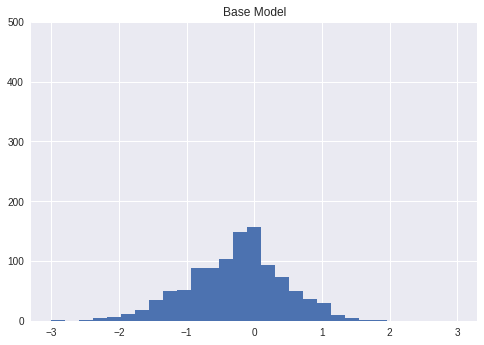

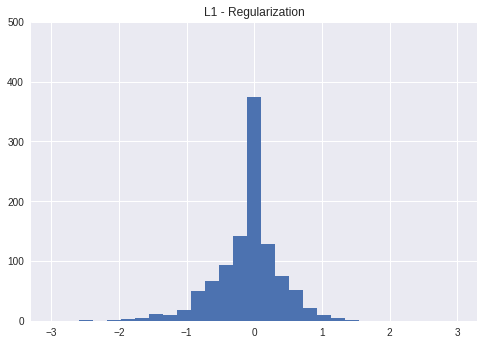

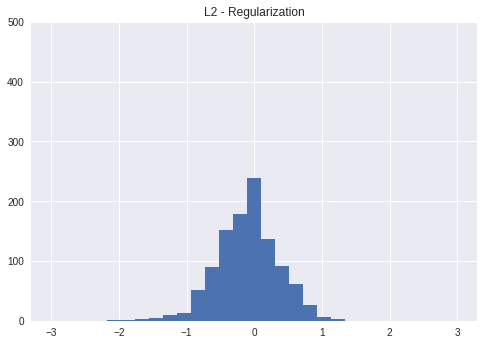

In [42]:
plt.figure()
_ = plt.hist(weights_base, bins=np.linspace(-3,3,30))
plt.title('Base Model')
plt.ylim([0,500])

plt.figure()
_ = plt.hist(weights_l1, bins=np.linspace(-3,3,30))
plt.title('L1 - Regularization')
plt.ylim([0,500])

plt.figure()
_ = plt.hist(weights_l2, bins=np.linspace(-3,3,30))
plt.title('L2 - Regularization')
_=plt.ylim([0,500])


Both types of regularization squeeze the distribution of weights towards zero. L2 regularization has a greater effect in the tails of the distribution eliminating extreme weights. L1 regularization produces more exactly-zero values, in this case it sets ~200 to zero.

